In [1]:
import os
import random
import numpy as np
import pandas as pd
import sys
import sklearn
import matplotlib.pyplot as plt
from summa import keywords
from nltk.tokenize import sent_tokenize , word_tokenize
import wikipedia
import spacy
from time import time
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.datasets import fetch_20newsgroups

In [2]:
text_data=pd.read_csv('speech100.csv',index_col= 0)
text_data

,Title,Lecturer,Year,Doc,clean,profession,gender,party,age_then
0,I Have A Dream,"Martin Luther King, Jr.",1963,I am happy to join with you today in what will...,happy join history great demonstration freedom...,American minister,male,Null,34
1,Inaugural Address,John Fitzgerald Kennedy,1961,"Vice President Johnson, Mr. Speaker, Mr. Chief...",vice johnson speaker chief justice eisenhower ...,35th U.S. President,male,Null,44
2,First Inaugural Address-Franklin Delano Roosevelt,Franklin Delano Roosevelt,1933,"President Hoover, Mr. Chief Justice, my friend...",hoover chief justice friend national consecrat...,32nd U.S. President,male,Democratic,51
3,Pearl Harbor Address to the Nation,Franklin Delano Roosevelt,1941,"Mr. Vice President, Mr. Speaker, Members of th...",vice speaker members senate house representati...,32nd U.S. President,male,Democratic,59
4,1976 DNC Keynote Address,Barbara Charline Jordan,1976,Thank you ladies and gentlemen for a very warm...,lady gentleman warm reception fortyfour member...,Former United States Representative,female,Null,40
...,...,...,...,...,...,...,...,...,...
95,Let Us Continue,Lyndon Baines Johnson,1963,"Mr. Speaker, Mr. President, Members of the Hou...",speaker members house members senate fellow gl...,36th U.S. President,male,Democratic,55
96,Have You Left No Sense of Decency,Joseph N. Welch,1954,"Senator McCarthy: Mr. Chairman, in view of tha...",senator mccarthy chairman view request senator...,American lawyer,male,Null,64
97,The Declaration of Human Rights,Anna Eleanor Roosevelt,1948,"Mr. President, fellow delegates: The long and ...",fellow delegate long meticulous study debate u...,Former First Lady of the United States,female,Null,64
98,Day of Affirmation Address at Cape Town Univer...,Robert Francis Kennedy,1966,"Mr. Chancellor, Mr. Vice Chancellor, Professor...",chancellor vice chancellor professor robertson...,Former United States Attorney General,male,Democratic,41


In [3]:
n_samples = 2000
n_features = 1000
n_components = 6
n_top_words = 20


def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, n_components, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()


# Load the 20 newsgroups dataset and vectorize it. We use a few heuristics
# to filter out useless terms early on: the posts are stripped of headers,
# footers and quoted replies, and common English words, words occurring in
# only one document or in at least 95% of the documents are removed.



In [4]:
# Use tf-idf features for NMF.
tfidf_vectorizer = TfidfVectorizer(max_features=n_features)
tfidf = tfidf_vectorizer.fit_transform(text_data['clean'])

**Question**\
tfidf_vectorizer = TfidfVectorizer(max_features=n_features)

我当时找的例子n_features设定的是1000，所以我在这里也设定的1000，他的意思就是只用前1000个代表性词汇。 答：没问题，用1000个词

max_featuresint, default=None
If not None, build a vocabulary that only consider the top max_features ordered by term frequency across the corpus

我试了试把他提高或者删除，就是用所有的词，他主题含义会稍微改变，然后词不像现在这样和主题关联度很高
不知道这个参数可不可以. 答：就这样吧，挺好的分的还是很清楚的。

# NMF with Kullback-leibler

/Users/yuxiangzong/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


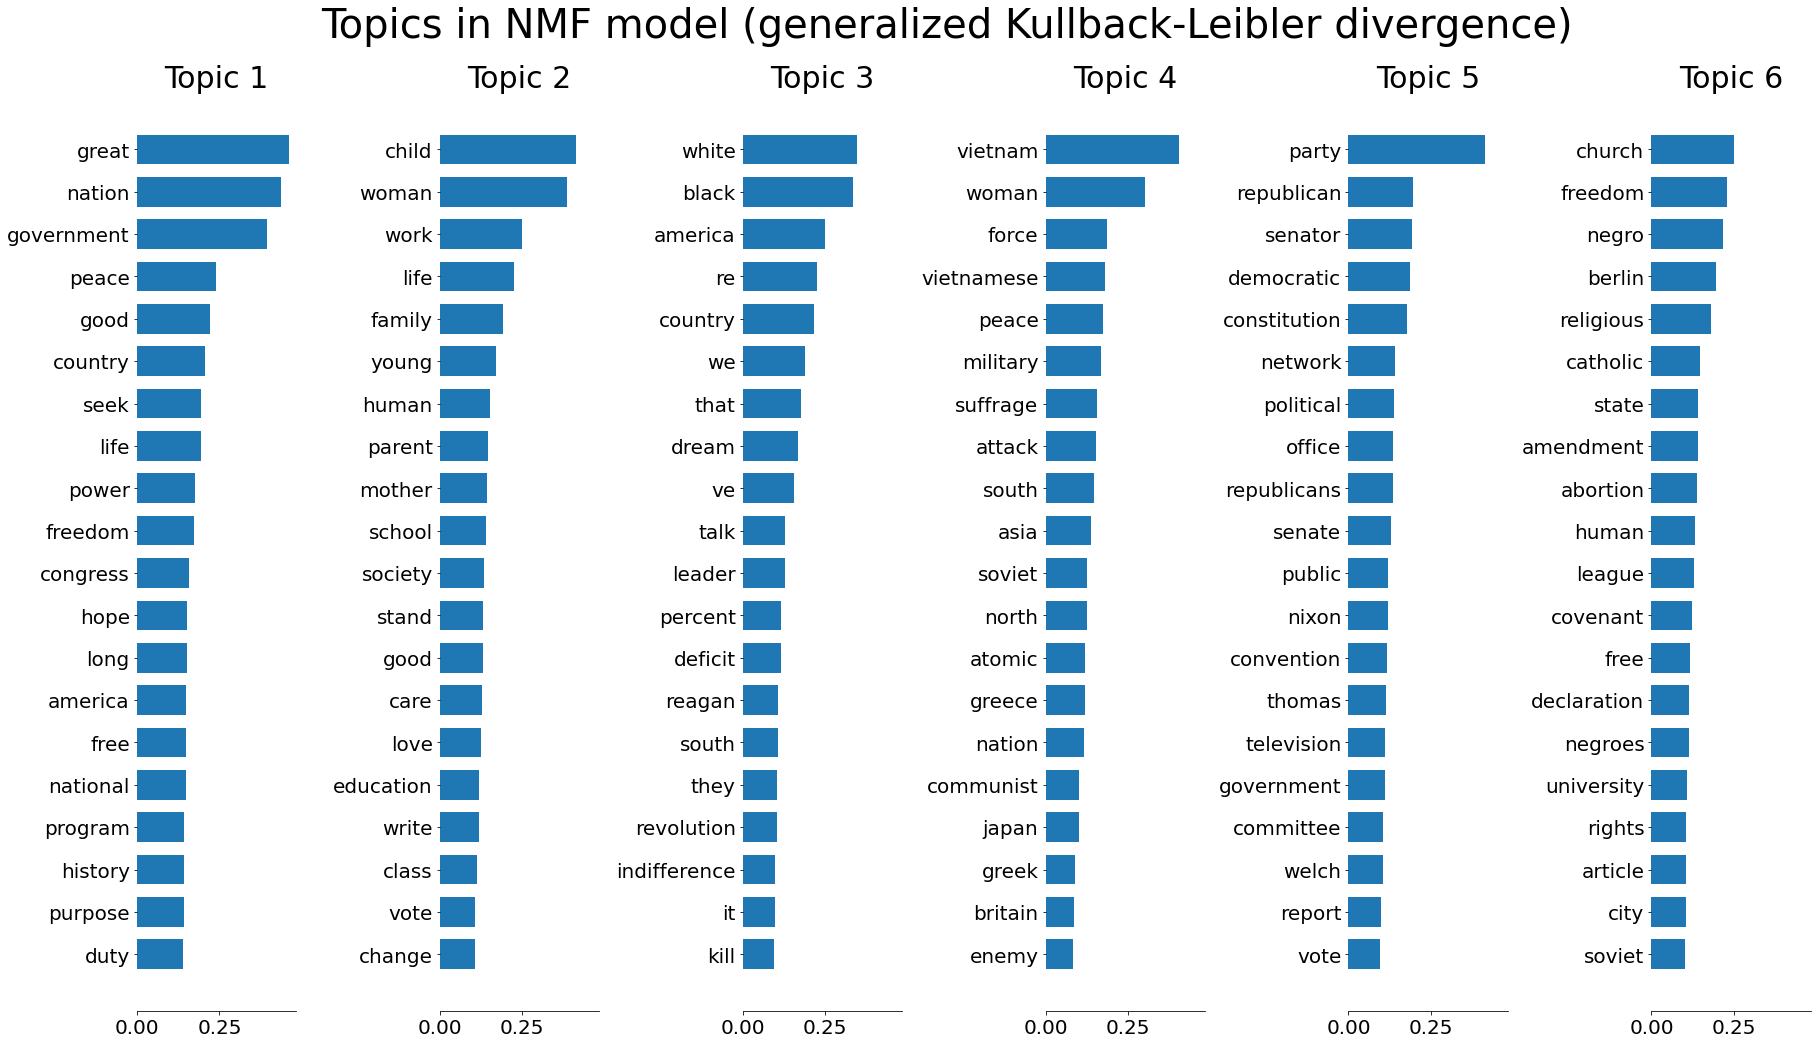

In [5]:
nmf = NMF(
    n_components=n_components,
    random_state=1,
    beta_loss="kullback-leibler",
    solver="mu",
    max_iter=1000,
    alpha=0.1,
    l1_ratio=0.5).fit(tfidf)


tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_top_words(
    nmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in NMF model (generalized Kullback-Leibler divergence)",
)

## Topic distribution
<span class="mark">1. American value/ Universal Value/ American Government\
2. Family/ Education/ Love/ Women\
3. Race\
4. War/ diplomatic\
5. Party/ constitution\
6. Religion</span>

**Question**\
这是我对我运行出来的topic模型主题的描述，结果在下图，我在这里设置了random_state 相同参数下运行NMF是一样的，但是不确定换了电脑会不会改变，请留意一下，要是改变了的话就以一个为准吧，因为后面也得随着改变. 答： 只要设置了random_state就可以了，放心。

## Frequency table

NMF using Kullback-leibler 属于每一类的文章篇数，很均衡

In [16]:
w=nmf.fit_transform(tfidf)
topic_doc=np.argmax(w, axis=1)
topic_doc
unique, counts = np.unique(topic_doc, return_counts=True)
print(np.asarray((unique, counts)).T)

[[ 0 22]
 [ 1 19]
 [ 2 13]
 [ 3 12]
 [ 4 17]
 [ 5 17]]


C:\Users\rebeccalai\anaconda3\envs\tensorflow\lib\site-packages\sklearn\decomposition\_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
C:\Users\rebeccalai\anaconda3\envs\tensorflow\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


w 每行的含义是文档的主题概率分布，如果需要的话请保存

In [44]:
#np.save("w.npy",w) 
# w.tolist() 不建议这样做，会导致数据太大

### Topic label 
(添加一列作为label，精简下一列中表达同一个topic的文章的code)

In [48]:
# 加一列作为NMF的model label
text_data['NMF_topic'] = [(w+1) for w in topic_doc]
text_data

,Title,Lecturer,Year,Doc,clean,profession,gender,party,age_then,NMF_topic
0,I Have A Dream,"Martin Luther King, Jr.",1963,I am happy to join with you today in what will...,happy join history great demonstration freedom...,American minister,male,Null,34,6
1,Inaugural Address,John Fitzgerald Kennedy,1961,"Vice President Johnson, Mr. Speaker, Mr. Chief...",vice johnson speaker chief justice eisenhower ...,35th U.S. President,male,Null,44,1
2,First Inaugural Address-Franklin Delano Roosevelt,Franklin Delano Roosevelt,1933,"President Hoover, Mr. Chief Justice, my friend...",hoover chief justice friend national consecrat...,32nd U.S. President,male,Democratic,51,1
3,Pearl Harbor Address to the Nation,Franklin Delano Roosevelt,1941,"Mr. Vice President, Mr. Speaker, Members of th...",vice speaker members senate house representati...,32nd U.S. President,male,Democratic,59,4
4,1976 DNC Keynote Address,Barbara Charline Jordan,1976,Thank you ladies and gentlemen for a very warm...,lady gentleman warm reception fortyfour member...,Former United States Representative,female,Null,40,5
...,...,...,...,...,...,...,...,...,...,...
95,Let Us Continue,Lyndon Baines Johnson,1963,"Mr. Speaker, Mr. President, Members of the Hou...",speaker members house members senate fellow gl...,36th U.S. President,male,Democratic,55,1
96,Have You Left No Sense of Decency,Joseph N. Welch,1954,"Senator McCarthy: Mr. Chairman, in view of tha...",senator mccarthy chairman view request senator...,American lawyer,male,Null,64,5
97,The Declaration of Human Rights,Anna Eleanor Roosevelt,1948,"Mr. President, fellow delegates: The long and ...",fellow delegate long meticulous study debate u...,Former First Lady of the United States,female,Null,64,6
98,Day of Affirmation Address at Cape Town Univer...,Robert Francis Kennedy,1966,"Mr. Chancellor, Mr. Vice Chancellor, Professor...",chancellor vice chancellor professor robertson...,Former United States Attorney General,male,Democratic,41,1


## Test

### Draw keywords from each topic

In [50]:
keywords_topic = []
for j in range(n_components):
    keywords_topic.append(keywords.keywords(" ".join([i for i in text_data['clean'][(topic_doc==j).tolist()]]),words=50).split('\n'))

In [18]:
for j in range(n_components):
    print("topic",j+1,":",keywords_topic[j],"\n")

topic 1 : ['nation', 'nations', 'national', 'nationally', 'nationalization', 'nationality', 'government', 'govern', 'governed', 'great', 'greatly', 'greatness', 'peace', 'peaceful', 'peacefully', 'life', 'good', 'goodness', 'goodly', 'country', 'freedom', 'power', 'powerful', 'powerfully', 'work', 'working', 'seek', 'long', 'longing', 'public', 'publicly', 'labor', 'laborer', 'americas', 'america', 'political', 'politic', 'politics', 'politically', 'human', 'humanity', 'humane', 'humanize', 'industrial', 'industry', 'force', 'problem', 'hope', 'free', 'economic', 'economical', 'economically', 'economics', 'bank', 'banks', 'effort', 'history', 'program', 'programs', 'republican', 'republicans', 'republicanism', 'purpose', 'secure', 'securely', 'security', 'stand', 'standing', 'face', 'faced', 'individual', 'individualism', 'individually', 'banking business', 'word place friend', 'friendly', 'congress', 'energy faith', 'strength', 'action', 'land', 'landing', 'lands', 'state', 'stately',

### Word cloud of every topic

In [109]:
add_stop_words = ['like','youre','ive','im','really','id','ve','just','dont','didnt','thi','wa',
                  'say','know','make','people',"today","way","day","time","year",'tonight']

boring_words = ['say','like','just','dont','don','im',
                'live','youll','youve','things','thing','youre','right','really','lot',
                'make','know','people','way','day',
                'little', 'maybe','men',"americans","america"
                'kind','heart', "american","president","united","states"         
                ]

gist_file = open("gist_stopwords.txt", "r")
content = gist_file.read()
stop_words = content.split(",")+boring_words+add_stop_words

In [99]:
topic=["Topic "+str(i+1) for i in range(6)]
topic

['Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5', 'Topic 6']

In [117]:
wordlist_topic=[]
for i in range(6):
    df=text_data.loc[text_data["NMF_topic"]==i+1]
    df_topic=df["clean"].tolist()
    wordlist_topic.append(" ".join(df_topic))

data={"Topic":topic,"Wordcloud":wordlist_topic}
df_wordcloud=pd.DataFrame(data)
df_wordcloud

,Topic,Wordcloud
0,Topic 1,vice johnson speaker chief justice eisenhower ...
1,Topic 2,ladies gentlemen plan speak report state union...
2,Topic 3,moderator cleage brother sister friend enemy f...
3,Topic 4,vice speaker members senate house representati...
4,Topic 5,lady gentleman warm reception fortyfour member...
5,Topic 6,happy join history great demonstration freedom...


In [130]:
%run word_cloud.py

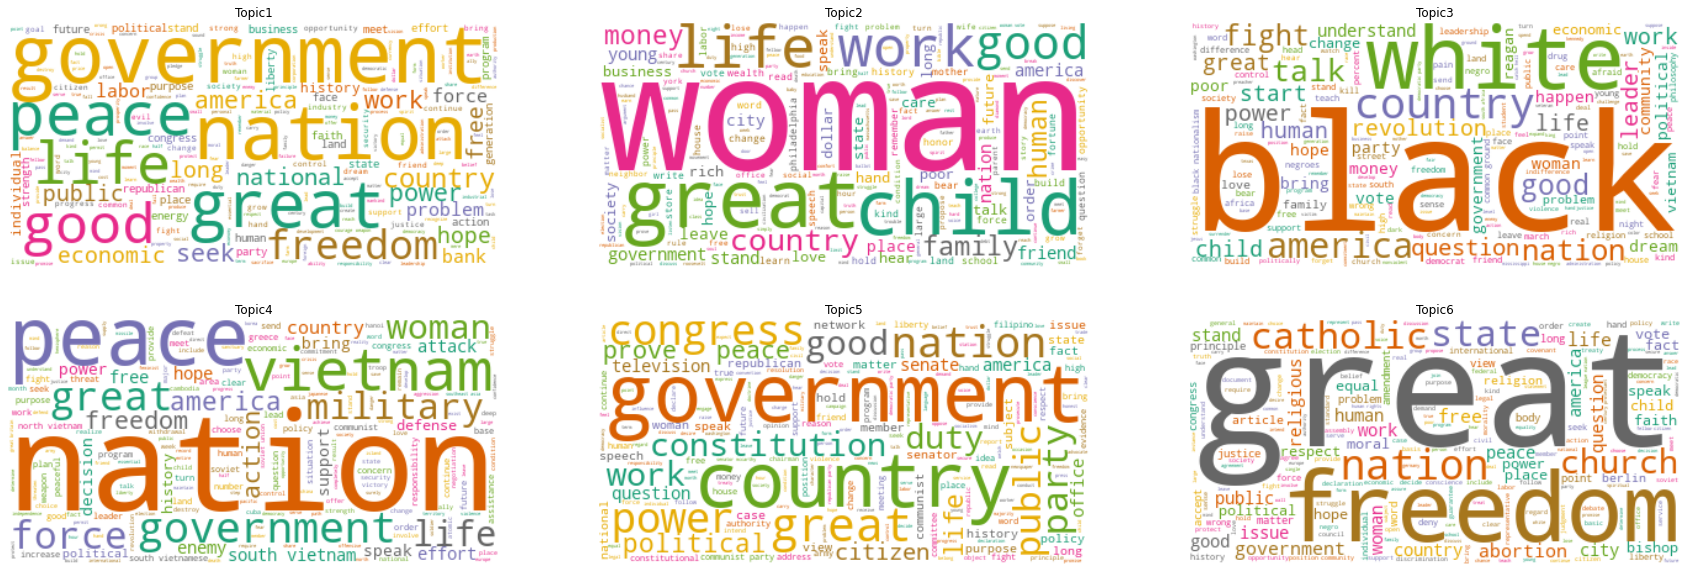

In [131]:
show_word_cloud(df_wordcloud,"Wordcloud",stop_words,collocation_threshold = 30)

### The distribution of time in each topic

In [98]:
for j in range(n_components):
    print("Topic",j+1,":",text_data['Year'][np.where(topic_doc==j)[0]].tolist(),"\n")

Topic 1 : [1961, 1933, 1906, 1961, 1917, 1962, 1964, 1981, 1933, 1963, 1974, 1941, 1947, 1984, 1937, 1964, 1980, 1932, 1913, 1979, 1963, 1966] 

Topic 2 : [1986, 1984, 1924, 1900, 1934, 1915, 1950, 1918, 1995, 1990, 1992, 1964, 1984, 1916, 1968, 1920, 1925, 1935, 1995] 

Topic 3 : [1964, 1984, 1968, 1968, 1988, 1988, 1966, 1939, 1992, 1983, 1963, 1999, 1971] 

Topic 4 : [1941, 1951, 1969, 1940, 1947, 1953, 1967, 1962, 1970, 1917, 1968, 1920] 

Topic 5 : [1976, 1952, 1974, 1950, 1900, 1969, 1952, 1917, 1969, 1948, 1917, 1961, 1991, 1974, 1952, 1974, 1954] 

Topic 6 : [1963, 1960, 1965, 1963, 1983, 1918, 1963, 1983, 1948, 1984, 1919, 1964, 1968, 1970, 1987, 1919, 1948] 



In [92]:
text_data['Topic']=[int(i)+1 for i in topic_doc.tolist()]

In [95]:
text_data.to_csv("speech_100_topic.csv",index=False)

### to be continued ,  more discuss about topic